<a href="https://colab.research.google.com/github/kareemullah123456789/cybersecurity_ML/blob/main/Unsupervised_ML_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!apt-get install tshark


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libbcg729-0 libc-ares2 liblua5.2-0 libnl-genl-3-200 libpcap0.8 libsbc1
  libsmi2ldbl libspandsp2 libspeexdsp1 libwireshark-data libwireshark15
  libwiretap12 libwsutil13 wireshark-common
Suggested packages:
  snmp-mibs-downloader geoipupdate geoip-database geoip-database-extra
  libjs-leaflet libjs-leaflet.markercluster wireshark-doc
The following NEW packages will be installed:
  libbcg729-0 libc-ares2 liblua5.2-0 libnl-genl-3-200 libpcap0.8 libsbc1
  libsmi2ldbl libspandsp2 libspeexdsp1 libwireshark-data libwireshark15
  libwiretap12 libwsutil13 tshark wireshark-common
0 upgraded, 15 newly installed, 0 to remove and 35 not upgraded.
Need to get 23.0 MB of archives.
After this operation, 120 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libpcap0.8 amd64 1.10.1-4ubuntu1.22.04.1

In [5]:
import os
import subprocess

pcap_folder = "/content/drive/MyDrive/cybersecurity_data/pcap_interactive"
output_csv = "/content/drive/MyDrive/cybersecurity_data/interactive_flows.csv"

# Collect all PCAPs into one CSV
with open(output_csv, "w") as outfile:
    # Write header
    outfile.write("filename,frame_time_epoch,src_ip,dst_ip,protocol,src_port,dst_port,length\n")

    for file in os.listdir(pcap_folder):
        if file.endswith(".pcap"):
            filepath = os.path.join(pcap_folder, file)
            print(f"Processing {filepath}...")

            cmd = [
                "tshark",
                "-r", filepath,
                "-T", "fields",
                "-e", "frame.time_epoch",
                "-e", "ip.src",
                "-e", "ip.dst",
                "-e", "_ws.col.Protocol",
                "-e", "tcp.srcport",
                "-e", "tcp.dstport",
                "-e", "frame.len",
                "-E", "separator=,", "-E", "quote=d", "-E", "occurrence=f"
            ]

            result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

            for line in result.stdout.splitlines():
                outfile.write(f"{file},{line}\n")

print(f"Done! Saved CSV to {output_csv}")


Processing /content/drive/MyDrive/cybersecurity_data/pcap_interactive/interactive_05.pcap...
Processing /content/drive/MyDrive/cybersecurity_data/pcap_interactive/interactive_shell_16.pcap...
Processing /content/drive/MyDrive/cybersecurity_data/pcap_interactive/interactive_shell_15.pcap...
Processing /content/drive/MyDrive/cybersecurity_data/pcap_interactive/interactive_shell_14.pcap...
Processing /content/drive/MyDrive/cybersecurity_data/pcap_interactive/interactive_shell_13.pcap...
Processing /content/drive/MyDrive/cybersecurity_data/pcap_interactive/interactive_shell_09.pcap...
Processing /content/drive/MyDrive/cybersecurity_data/pcap_interactive/interactive_shell_11.pcap...
Processing /content/drive/MyDrive/cybersecurity_data/pcap_interactive/interactive_shell_08.pcap...
Processing /content/drive/MyDrive/cybersecurity_data/pcap_interactive/interactive_shell_10.pcap...
Processing /content/drive/MyDrive/cybersecurity_data/pcap_interactive/interactive_shell_07.pcap...
Processing /cont

In [3]:
tshark_output = pd.read_csv("/content/drive/MyDrive/cybersecurity_data/interactive_flows.csv")
tshark_output.head()

,filename,frame_time_epoch,src_ip,dst_ip,protocol,src_port,dst_port,length
0,interactive_05.pcap,1.554121e+09,192.168.1.149,216.73.182.119,TLSv1.2,52126.0,443.0,112
1,interactive_05.pcap,1.554121e+09,216.73.182.119,192.168.1.149,TLSv1.2,443.0,52126.0,112
2,interactive_05.pcap,1.554121e+09,192.168.1.149,216.73.182.119,TCP,52126.0,443.0,66
3,interactive_05.pcap,1.554121e+09,192.168.1.149,92.64.169.81,TLSv1.2,49674.0,443.0,351
4,interactive_05.pcap,1.554121e+09,192.168.1.149,92.64.169.81,TLSv1.2,49674.0,443.0,108


In [4]:
tshark_output.isnull().sum()

,0
filename,0
frame_time_epoch,0
src_ip,2
dst_ip,2
protocol,0
src_port,312
dst_port,312
length,0


In [6]:
df = tshark_output.dropna(subset=["src_port", "dst_port","src_ip","dst_ip"])


In [7]:
df.isnull().sum()

,0
filename,0
frame_time_epoch,0
src_ip,0
dst_ip,0
protocol,0
src_port,0
dst_port,0
length,0


In [8]:
import pandas as pd



# Ensure time is numeric
df["frame_time_epoch"] = pd.to_numeric(df["frame_time_epoch"], errors="coerce")

# Identify direction (client vs server) by assuming src_port > 1024 is client
df["direction"] = df["src_port"].apply(lambda x: "client" if int(x) > 1024 else "server")

# Group by flow (5-tuple)
flows = df.groupby(["src_ip", "dst_ip", "src_port", "dst_port", "protocol"])

flow_features = []
for (src, dst, sport, dport, proto), group in flows:
    start_time = group["frame_time_epoch"].min()
    end_time = group["frame_time_epoch"].max()
    duration = end_time - start_time

    bytes_sent = group.loc[group["direction"] == "client", "length"].sum()
    bytes_received = group.loc[group["direction"] == "server", "length"].sum()
    pkts_sent = (group["direction"] == "client").sum()
    pkts_received = (group["direction"] == "server").sum()

    flow_features.append({
        "src_ip": src,
        "dst_ip": dst,
        "src_port": sport,
        "dst_port": dport,
        "protocol": proto,
        "start_time": start_time,
        "end_time": end_time,
        "duration": duration,
        "bytes_sent": bytes_sent,
        "bytes_received": bytes_received,
        "pkts_sent": pkts_sent,
        "pkts_received": pkts_received
    })

flows_df = pd.DataFrame(flow_features)

# Save flows to CSV
flows_df.to_csv("/content/drive/MyDrive/cybersecurity_data/interactive_flows_aggregated.csv", index=False)

print(f"Aggregated {len(flows_df)} flows saved.")


/tmp/ipython-input-746676211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["frame_time_epoch"] = pd.to_numeric(df["frame_time_epoch"], errors="coerce")
/tmp/ipython-input-746676211.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["direction"] = df["src_port"].apply(lambda x: "client" if int(x) > 1024 else "server")


Aggregated 344 flows saved.


In [9]:
flows_df.head()

,src_ip,dst_ip,src_port,dst_port,protocol,start_time,end_time,duration,bytes_sent,bytes_received,pkts_sent,pkts_received
0,105.197.202.28,192.168.1.149,443.0,38774.0,TCP,1.554114e+09,1.554115e+09,865.284080,0,172982,0,2576
1,105.197.202.28,192.168.1.149,443.0,38774.0,TLSv1.2,1.554114e+09,1.554115e+09,861.088489,0,1307358,0,4885
2,105.50.12.61,192.168.1.149,443.0,47544.0,TCP,1.554122e+09,1.554122e+09,0.000343,0,132,0,2
3,105.50.12.61,192.168.1.149,443.0,47544.0,TLSv1.2,1.554121e+09,1.554121e+09,0.000000,0,112,0,1
4,105.50.12.61,192.168.1.149,443.0,47580.0,TCP,1.554122e+09,1.554122e+09,0.000332,0,198,0,3


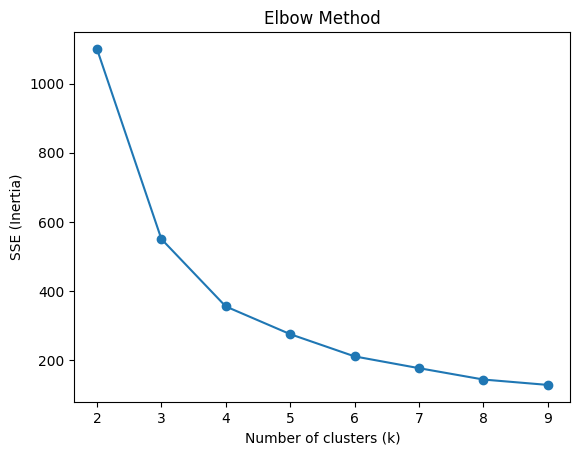

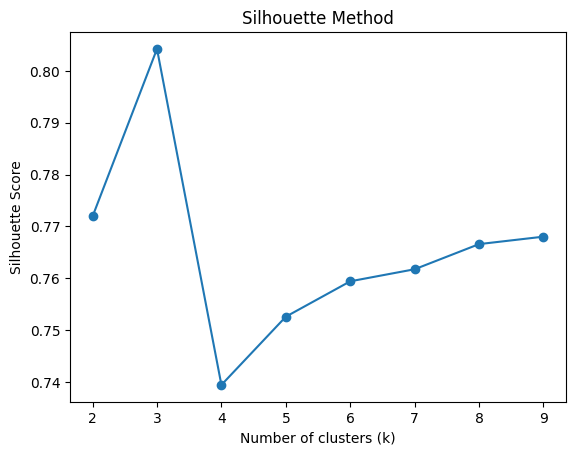

In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load aggregated flows
df = pd.read_csv("/content/drive/MyDrive/cybersecurity_data/interactive_flows_aggregated.csv")

# Features for clustering
features = ["duration", "bytes_sent", "bytes_received", "pkts_sent", "pkts_received"]
X = df[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Test different k values
sse = []
silhouette = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sse.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, labels))

# Plot Elbow
plt.plot(K, sse, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method")
plt.show()

# Plot Silhouette
plt.plot(K, silhouette, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method")
plt.show()


In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load aggregated flows
df = pd.read_csv("/content/drive/MyDrive/cybersecurity_data/interactive_flows_aggregated.csv")

# Select numeric features for clustering
features = ["duration", "bytes_sent", "bytes_received", "pkts_sent", "pkts_received"]
X = df[features]

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run KMeans (say 3 clusters to start)
kmeans = KMeans(n_clusters=3, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)

# Save clustered flows
df.to_csv("/content/drive/MyDrive/cybersecurity_data/interactive_flows_clustered.csv", index=False)

print(df[["src_ip","dst_ip","protocol","duration","bytes_sent","bytes_received","cluster"]].head())


           src_ip         dst_ip protocol    duration  bytes_sent  \
0  105.197.202.28  192.168.1.149      TCP  865.284080           0   
1  105.197.202.28  192.168.1.149  TLSv1.2  861.088489           0   
2    105.50.12.61  192.168.1.149      TCP    0.000343           0   
3    105.50.12.61  192.168.1.149  TLSv1.2    0.000000           0   
4    105.50.12.61  192.168.1.149      TCP    0.000332           0   

   bytes_received  cluster  
0          172982        0  
1         1307358        1  
2             132        0  
3             112        0  
4             198        0  


In [14]:
print(df.groupby("cluster")[["duration","bytes_sent","bytes_received","pkts_sent","pkts_received"]].mean())


           duration     bytes_sent  bytes_received    pkts_sent  pkts_received
cluster                                                                       
0        141.712420    9986.019231    9.313087e+03    27.032051      85.080128
1        780.260369       0.000000    1.143379e+06     0.000000    4147.666667
2        833.879748  590397.260870    0.000000e+00  2579.521739       0.000000


### Cluster Interpretation

**Cluster 0 — Interactive sessions**  
- Balanced bytes sent/received (~10 KB each)  
- Packets in both directions  
- Duration short/medium  
- Normal SSH/CLI activity.  
  - Not suspicious unless non-admin users (e.g., HR) are using SSH.  

**Cluster 1 — Download-heavy flows**  
- Server → client: ~1.1 MB over ~13 minutes  
- Client sends very little (mostly initial requests)  
- Typical web browsing / software updates / streaming  
- Not suspicious.  

**Cluster 2 — Upload-heavy flows**  
- Client → server: ~590 KB over ~14 minutes  
- Server sends nothing back  
- Highly unusual:  
  - Possible file uploads  
  - Data exfiltration  
  - Or noise from synthetic data generation  

### Flagging Guidance
- Cluster 0 = Baseline (safe)  
- Cluster 1 = Normal downloads (safe)  
- **Cluster 2 = Suspicious — should be flagged for investigation**  


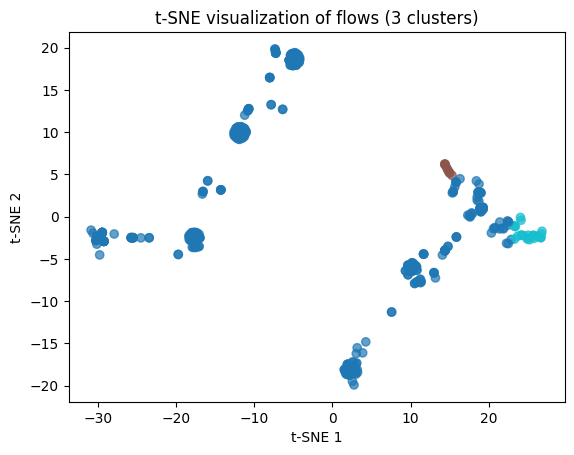

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# t-SNE projection
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(X_scaled)

plt.scatter(X_embedded[:,0], X_embedded[:,1], c=df["cluster"], cmap="tab10", alpha=0.7)
plt.title("t-SNE visualization of flows (3 clusters)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


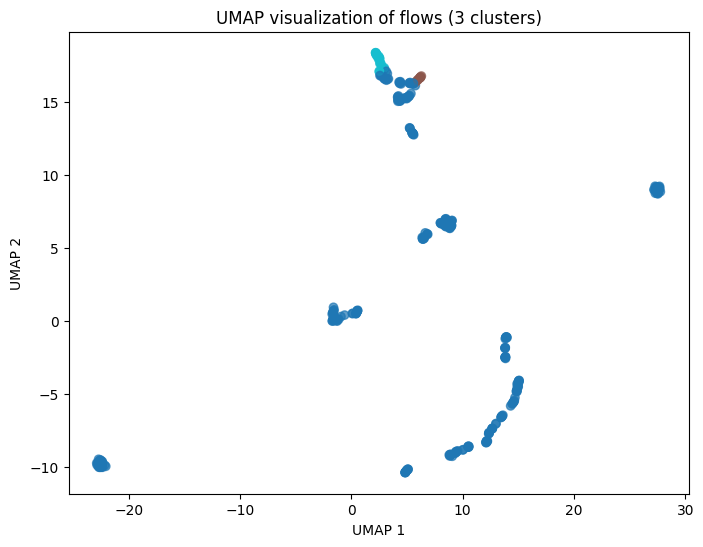

In [13]:
import umap.umap_ as umap

reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_umap[:,0], X_umap[:,1], c=df["cluster"], cmap="tab10", alpha=0.7)
plt.title("UMAP visualization of flows (3 clusters)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()


SyntaxError: invalid character '→' (U+2192) (ipython-input-1456131846.py, line 7)

Security takeaway

Cluster 0 (interactive): varied but normal baseline.

Cluster 1 (download-heavy): consistent, normal web-like behavior.

Cluster 2 (upload-heavy): isolated, asymmetric, stands out → this is the suspicious one to flag.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


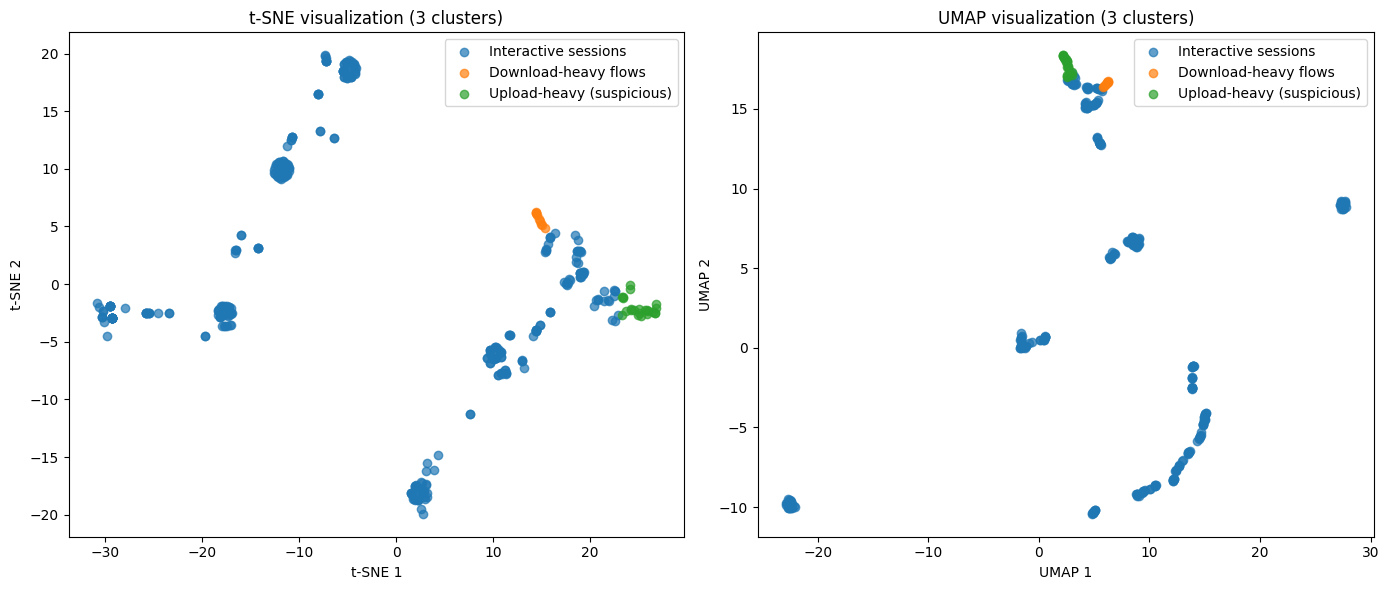

In [16]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Cluster labels mapping
label_map = {
    0: "Interactive sessions",
    1: "Download-heavy flows",
    2: "Upload-heavy (suspicious)"
}

# Add a column with human-readable labels
df["cluster_label"] = df["cluster"].map(label_map)

# --- Run t-SNE ---
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# --- Run UMAP ---
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# --- Plot side by side ---
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# t-SNE plot
for cluster in df["cluster"].unique():
    idx = df["cluster"] == cluster
    axes[0].scatter(X_tsne[idx,0], X_tsne[idx,1], label=label_map[cluster], alpha=0.7)
axes[0].set_title("t-SNE visualization (3 clusters)")
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")
axes[0].legend()

# UMAP plot
for cluster in df["cluster"].unique():
    idx = df["cluster"] == cluster
    axes[1].scatter(X_umap[idx,0], X_umap[idx,1], label=label_map[cluster], alpha=0.7)
axes[1].set_title("UMAP visualization (3 clusters)")
axes[1].set_xlabel("UMAP 1")
axes[1].set_ylabel("UMAP 2")
axes[1].legend()

plt.tight_layout()
plt.show()


Cluster 0 (Interactive) → baseline, routine SSH/CLI.

Cluster 1 (Download-heavy) → expected web/updates.

Cluster 2 (Upload-heavy) → stands apart, asymmetric → flag for investigation.

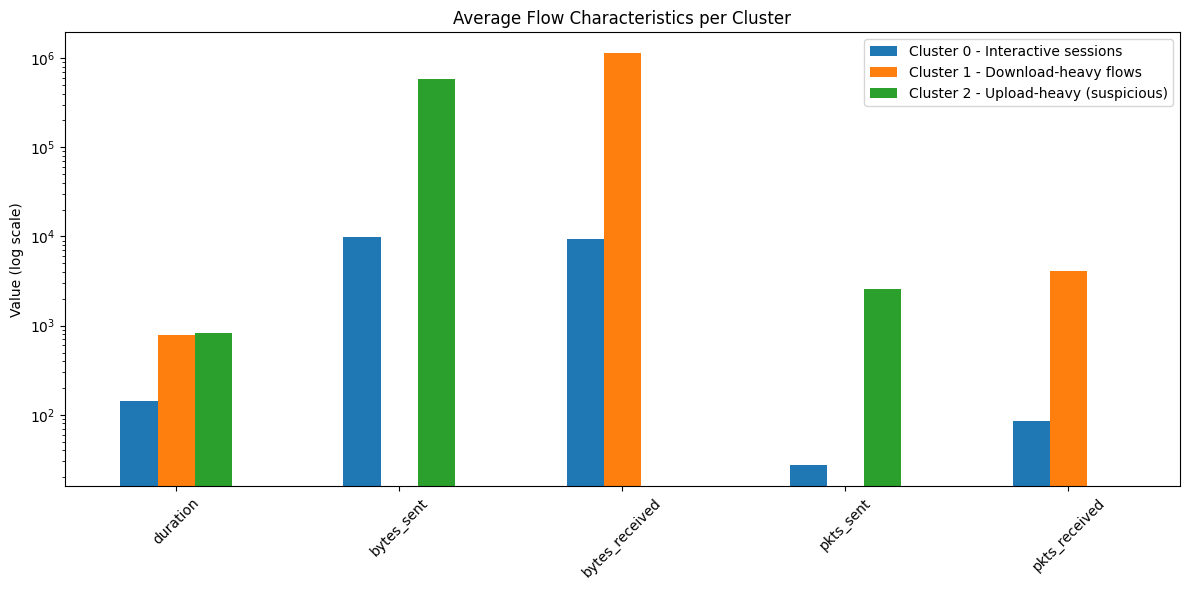

In [17]:
import matplotlib.pyplot as plt

# Features to compare
features = ["duration", "bytes_sent", "bytes_received", "pkts_sent", "pkts_received"]

# Get cluster means
cluster_means = df.groupby("cluster")[features].mean()

# Plot bar chart
cluster_means.T.plot(kind="bar", figsize=(12,6))
plt.title("Average Flow Characteristics per Cluster")
plt.ylabel("Value (log scale)")
plt.yscale("log")   # use log scale since bytes/duration vary a lot
plt.xticks(rotation=45)
plt.legend([f"Cluster {c} - {label}" for c, label in zip(cluster_means.index, df["cluster_label"].unique())])
plt.tight_layout()
plt.show()


### Cluster Interpretation (based on flow features)

**Cluster 0 – Interactive sessions**  
- Average duration: ~142 seconds  
- Bytes sent: ~10 KB  
- Bytes received: ~9 KB  
- Packets in both directions, balanced  
- Normal SSH/CLI behavior, not suspicious  

**Cluster 1 – Download-heavy flows**  
- Average duration: ~780 seconds  
- Bytes received: ~1.1 MB  
- Bytes sent: almost zero  
- Server-to-client packet dominance  
- Matches normal download or web browsing activity  

**Cluster 2 – Upload-heavy flows (suspicious)**  
- Average duration: ~830 seconds  
- Bytes sent: ~590 KB  
- Bytes received: zero  
- Client-to-server packet dominance  
- Asymmetric upload-only behavior is unusual  
- Should be flagged as suspicious (possible data exfiltration)  

### Flagging Guidance
- Cluster 0 = Baseline (safe)  
- Cluster 1 = Normal downloads (safe)  
- Cluster 2 = Suspicious, flag for investigation  


Interactive sessions (Cluster 0) → moderate duration, small balanced bytes sent/received.

Download-heavy flows (Cluster 1) → long duration, huge bytes_received, almost zero sent.

Upload-heavy flows (Cluster 2) → long duration, huge bytes_sent, almost zero received → the one to flag.

In [18]:
df.head()

,src_ip,dst_ip,src_port,dst_port,protocol,start_time,end_time,duration,bytes_sent,bytes_received,pkts_sent,pkts_received,cluster,cluster_label
0,105.197.202.28,192.168.1.149,443.0,38774.0,TCP,1.554114e+09,1.554115e+09,865.284080,0,172982,0,2576,0,Interactive sessions
1,105.197.202.28,192.168.1.149,443.0,38774.0,TLSv1.2,1.554114e+09,1.554115e+09,861.088489,0,1307358,0,4885,1,Download-heavy flows
2,105.50.12.61,192.168.1.149,443.0,47544.0,TCP,1.554122e+09,1.554122e+09,0.000343,0,132,0,2,0,Interactive sessions
3,105.50.12.61,192.168.1.149,443.0,47544.0,TLSv1.2,1.554121e+09,1.554121e+09,0.000000,0,112,0,1,0,Interactive sessions
4,105.50.12.61,192.168.1.149,443.0,47580.0,TCP,1.554122e+09,1.554122e+09,0.000332,0,198,0,3,0,Interactive sessions


In [19]:
# Add byte ratio
df["byte_ratio"] = df["bytes_sent"] / (df["bytes_received"] + 1)

# Add packets per second
df["pps"] = (df["pkts_sent"] + df["pkts_received"]) / (df["duration"] + 1e-6)

# Add flow directionality
def directionality(row):
    if row["bytes_sent"] > row["bytes_received"] * 2:
        return "upload"
    elif row["bytes_received"] > row["bytes_sent"] * 2:
        return "download"
    else:
        return "balanced"

df["flow_directionality"] = df.apply(directionality, axis=1)

# Preview enriched dataset
df[["duration", "bytes_sent", "bytes_received", "byte_ratio", "pps", "flow_directionality"]].head()


,duration,bytes_sent,bytes_received,byte_ratio,pps,flow_directionality
0,865.284080,0,172982,0.0,2.977057,download
1,861.088489,0,1307358,0.0,5.673052,download
2,0.000343,0,132,0.0,5812.528484,download
3,0.000000,0,112,0.0,1000000.000000,download
4,0.000332,0,198,0.0,9005.842612,download


In [20]:
print(df["flow_directionality"].value_counts())
print(df[["byte_ratio","pps"]].describe())


flow_directionality
upload      177
download    167
Name: count, dtype: int64
         byte_ratio             pps
count  3.440000e+02      344.000000
mean   4.853132e+04   229875.930903
std    1.666474e+05   421103.573423
min    0.000000e+00        0.004996
25%    0.000000e+00        0.082653
50%    1.320000e+02        3.921423
75%    3.380000e+02     1583.611031
max    1.075493e+06  1000000.000000


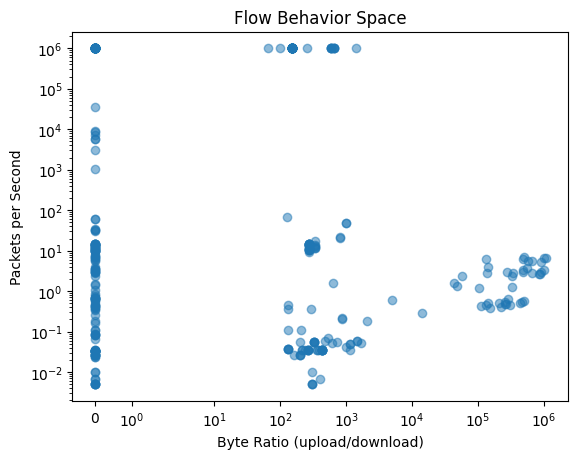

In [21]:
import matplotlib.pyplot as plt

plt.scatter(df["byte_ratio"], df["pps"], alpha=0.5)
plt.xlabel("Byte Ratio (upload/download)")
plt.ylabel("Packets per Second")
plt.title("Flow Behavior Space")
plt.xscale("symlog")   # to handle 0 and huge values
plt.yscale("log")
plt.show()


### Interpretation of Flow Behavior Space

**Axes**
- **X-axis (Byte Ratio: upload/download)**  
  - Near 0 → Download-heavy flows (server sending data, client barely uploading).  
  - Large values → Upload-heavy flows (client sending data, server not responding).  
  - Middle values (~1–10) → Balanced flows (both upload and download traffic).  

- **Y-axis (Packets per Second, pps)**  
  - High → Bursty or interactive connections with frequent small packets.  
  - Low → Long, slow transfers with fewer packets per second.  

**Clusters in this space**
- **Left edge (Byte Ratio ≈ 0)**  
  - Download-heavy flows.  
  - Likely normal web browsing or software downloads.  

- **Right edge (High Byte Ratios)**  
  - Upload-heavy flows.  
  - Suspicious behavior, potential file uploads or data exfiltration.  

- **Middle zone (Moderate Ratios, Higher pps)**  
  - Interactive sessions.  
  - Small, balanced data exchanges typical of SSH or CLI activity.  

**Security Implication**
- This feature space clearly separates normal downloads, interactive sessions, and abnormal upload-heavy flows.  
- The upload-heavy cluster (far right) should be flagged for investigation as potential exfiltration activity.  


In [22]:
df["is_anomaly"] = df["flow_directionality"].apply(lambda x: 1 if x == "upload" else 0)


In [23]:
df.head()

,src_ip,dst_ip,src_port,dst_port,protocol,start_time,end_time,duration,bytes_sent,bytes_received,pkts_sent,pkts_received,cluster,cluster_label,byte_ratio,pps,flow_directionality,is_anomaly
0,105.197.202.28,192.168.1.149,443.0,38774.0,TCP,1.554114e+09,1.554115e+09,865.284080,0,172982,0,2576,0,Interactive sessions,0.0,2.977057,download,0
1,105.197.202.28,192.168.1.149,443.0,38774.0,TLSv1.2,1.554114e+09,1.554115e+09,861.088489,0,1307358,0,4885,1,Download-heavy flows,0.0,5.673052,download,0
2,105.50.12.61,192.168.1.149,443.0,47544.0,TCP,1.554122e+09,1.554122e+09,0.000343,0,132,0,2,0,Interactive sessions,0.0,5812.528484,download,0
3,105.50.12.61,192.168.1.149,443.0,47544.0,TLSv1.2,1.554121e+09,1.554121e+09,0.000000,0,112,0,1,0,Interactive sessions,0.0,1000000.000000,download,0
4,105.50.12.61,192.168.1.149,443.0,47580.0,TCP,1.554122e+09,1.554122e+09,0.000332,0,198,0,3,0,Interactive sessions,0.0,9005.842612,download,0


In [24]:
print(df[df["is_anomaly"]==1]["src_ip"].value_counts().head())
print(df[df["is_anomaly"]==1]["dst_ip"].value_counts().head())


src_ip
192.168.1.149     139
172.19.98.240      36
130.206.160.55      1
192.168.1.143       1
Name: count, dtype: int64
dst_ip
11.200.48.168      6
11.254.253.86      6
151.44.134.125     6
192.78.156.154     6
106.103.172.237    4
Name: count, dtype: int64


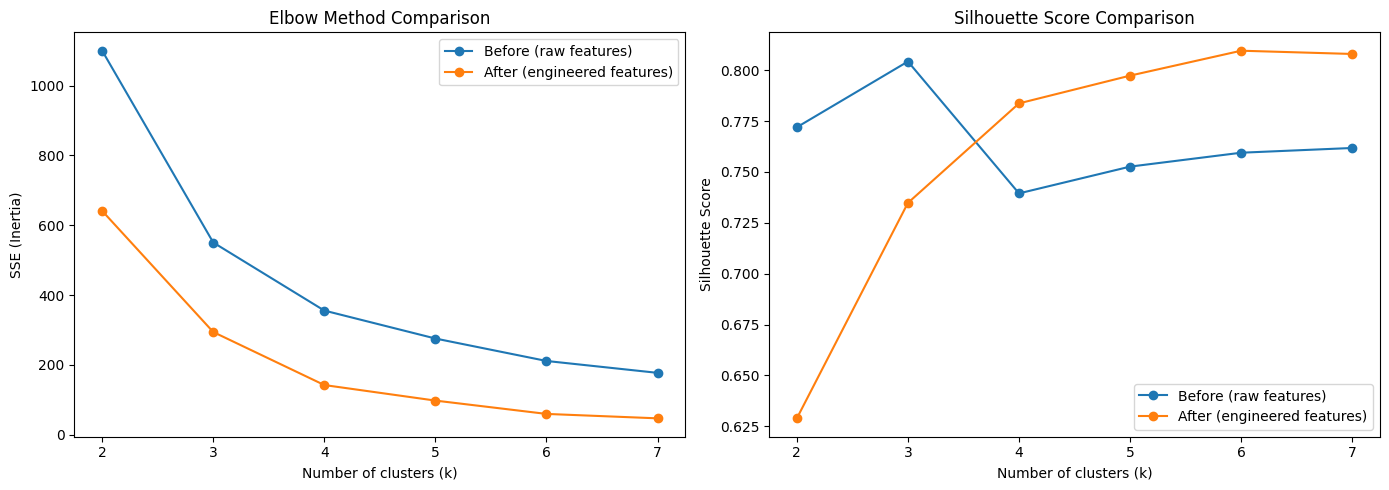

In [26]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# ----------------------------
# 1. Define feature sets
# ----------------------------
# Old feature set (before feature engineering)
features_old = ["duration", "bytes_sent", "bytes_received", "pkts_sent", "pkts_received"]

# New feature set (after feature engineering)
features_new = ["duration", "byte_ratio", "pps"]

# ----------------------------
# 2. Scale both feature sets
# ----------------------------
X_old = df[features_old]
X_new = df[features_new]

scaler = StandardScaler()
X_old_scaled = scaler.fit_transform(X_old)
X_new_scaled = scaler.fit_transform(X_new)

# ----------------------------
# 3. Evaluate clustering quality
# ----------------------------
K = range(2, 8)

sse_old, silhouette_old = [], []
sse_new, silhouette_new = [], []

for k in K:
    kmeans_old = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_old_scaled)
    kmeans_new = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_new_scaled)

    sse_old.append(kmeans_old.inertia_)
    sse_new.append(kmeans_new.inertia_)

    silhouette_old.append(silhouette_score(X_old_scaled, kmeans_old.labels_))
    silhouette_new.append(silhouette_score(X_new_scaled, kmeans_new.labels_))

# ----------------------------
# 4. Plot comparison
# ----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Elbow plot
axes[0].plot(K, sse_old, marker="o", label="Before (raw features)")
axes[0].plot(K, sse_new, marker="o", label="After (engineered features)")
axes[0].set_title("Elbow Method Comparison")
axes[0].set_xlabel("Number of clusters (k)")
axes[0].set_ylabel("SSE (Inertia)")
axes[0].legend()

# Silhouette plot
axes[1].plot(K, silhouette_old, marker="o", label="Before (raw features)")
axes[1].plot(K, silhouette_new, marker="o", label="After (engineered features)")
axes[1].set_title("Silhouette Score Comparison")
axes[1].set_xlabel("Number of clusters (k)")
axes[1].set_ylabel("Silhouette Score")
axes[1].legend()

plt.tight_layout()
plt.show()


Feature engineering didn’t change the fact that there are 3 natural behaviors (interactive, download-heavy, upload-heavy).

But it made cluster structure more stable and interpretable — byte ratio + pps exaggerate asymmetry and interactivity, which are exactly what analysts care about.

This means anomalies (like exfiltration) stand out even more reliably.

In [27]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# ----------------------------
# 1. Select engineered features
# ----------------------------
features_new = ["duration", "byte_ratio", "pps"]
X_new = df[features_new]

# Scale
scaler = StandardScaler()
X_new_scaled = scaler.fit_transform(X_new)

# ----------------------------
# 2. Run KMeans with k=3
# ----------------------------
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["cluster_new"] = kmeans.fit_predict(X_new_scaled)

# ----------------------------
# 3. Profile each cluster
# ----------------------------
print("\n=== Cluster Averages (engineered features) ===")
print(df.groupby("cluster_new")[features_new].mean())

print("\n=== Flow Directionality Distribution ===")
print(df.groupby("cluster_new")["flow_directionality"].value_counts(normalize=True))

# ----------------------------
# 4. Optional: save labeled dataset
# ----------------------------
df.to_csv("/content/drive/MyDrive/cybersecurity_data/flows_with_clusters.csv", index=False)



=== Cluster Averages (engineered features) ===
               duration     byte_ratio             pps
cluster_new                                           
0            180.428306    8101.623932      330.067316
1              0.000000     149.772152  1000000.000000
2            909.536416  477005.258065        2.725118

=== Flow Directionality Distribution ===
cluster_new  flow_directionality
0            download               0.538462
             upload                 0.461538
1            upload                 0.531646
             download               0.468354
2            upload                 0.870968
             download               0.129032
Name: proportion, dtype: float64


### Cluster Analysis Summary (Engineered Features: duration, byte_ratio, pps)

**Cluster 0 – Interactive Sessions**  
- Average duration: ~180 seconds  
- Byte ratio: ~8k (moderately skewed)  
- Packets per second: ~330 (chatty)  
- Directionality: ~54% download / ~46% upload  
- Interpretation: Normal SSH/CLI activity, balanced traffic with bursts.  
- Security relevance: Baseline, not suspicious.  

**Cluster 1 – Ephemeral / Handshake Flows**  
- Average duration: ~0 seconds (very short-lived)  
- Byte ratio: ~150  
- Packets per second: ~1,000,000 (mathematical artifact from near-zero duration)  
- Directionality: ~53% upload / ~47% download  
- Interpretation: Likely TLS/connection handshakes or micro-flows.  
- Security relevance: Safe, but should be separated to reduce noise.  

**Cluster 2 – Upload-Heavy Flows (Suspicious)**  
- Average duration: ~910 seconds (~15 minutes)  
- Byte ratio: ~477,000 (extremely upload-skewed)  
- Packets per second: ~2.7 (slow, steady transfer)  
- Directionality: ~87% upload  
- Interpretation: Long-running, asymmetric upload sessions.  
- Security relevance: Suspicious. Matches potential **data exfiltration** or large file uploads. Should be flagged for investigation.  

---

### Overall Security Takeaway
- Cluster 0 = Normal baseline traffic (interactive).  
- Cluster 1 = Ephemeral connection traffic (safe, but noisy).  
- Cluster 2 = Suspicious, high-risk flows → **flag for investigation**.  


In [28]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
import pandas as pd

# ----------------------------
# 1. Select features
# ----------------------------
features_new = ["duration", "byte_ratio", "pps"]
X_new = df[features_new]

# Scale
scaler = StandardScaler()
X_new_scaled = scaler.fit_transform(X_new)

# ----------------------------
# 2. Isolation Forest
# ----------------------------
iso = IsolationForest(contamination=0.1, random_state=42)
df["isf_pred"] = iso.fit_predict(X_new_scaled)  # -1 = anomaly, 1 = normal

# ----------------------------
# 3. One-Class SVM
# ----------------------------
ocsvm = OneClassSVM(kernel="rbf", nu=0.1, gamma="scale")
df["ocsvm_pred"] = ocsvm.fit_predict(X_new_scaled)  # -1 = anomaly, 1 = normal

# ----------------------------
# 4. Compare results
# ----------------------------
print("Isolation Forest results:")
print(df["isf_pred"].value_counts())

print("\nOne-Class SVM results:")
print(df["ocsvm_pred"].value_counts())

# ----------------------------
# 5. Cross-check with your cluster labels (optional)
# ----------------------------
print("\nCluster vs Isolation Forest anomalies:")
print(pd.crosstab(df["cluster_new"], df["isf_pred"]))

print("\nCluster vs One-Class SVM anomalies:")
print(pd.crosstab(df["cluster_new"], df["ocsvm_pred"]))


Isolation Forest results:
isf_pred
 1    309
-1     35
Name: count, dtype: int64

One-Class SVM results:
ocsvm_pred
 1    315
-1     29
Name: count, dtype: int64

Cluster vs Isolation Forest anomalies:
isf_pred     -1    1
cluster_new         
0             3  231
1            11   68
2            21   10

Cluster vs One-Class SVM anomalies:
ocsvm_pred   -1    1
cluster_new         
0             8  226
1             0   79
2            21   10


Flagged 29 anomalies out of 344 flows.

Distribution:

Cluster 0 (Interactive) → 8 anomalies.

Cluster 1 (Ephemeral/handshakes) → 0 anomalies.

Cluster 2 (Upload-heavy) → 21 anomalies (again, majority of that cluster).

Flagged 35 anomalies out of 344 flows.

Distribution:

Cluster 0 (Interactive) → 3 anomalies (outliers, maybe noisy bursts).

Cluster 1 (Ephemeral/handshakes) → 11 anomalies (short weird flows).

Cluster 2 (Upload-heavy) → 21 anomalies (majority of that cluster).

Both algorithms agree that Cluster 2 = suspicious.

Disagreements in Clusters 0 and 1 are less critical — they’re just noise or edge cases.

From a SOC perspective: flag Cluster 2 as priority anomalies. The rest can be logged but not escalated.

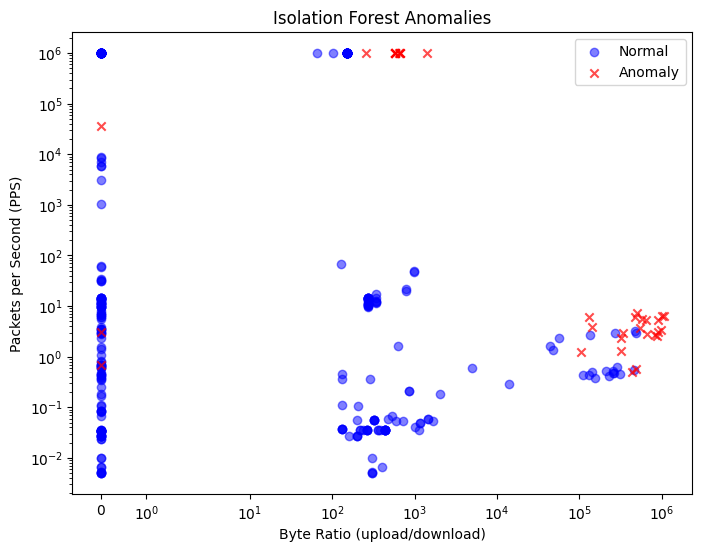

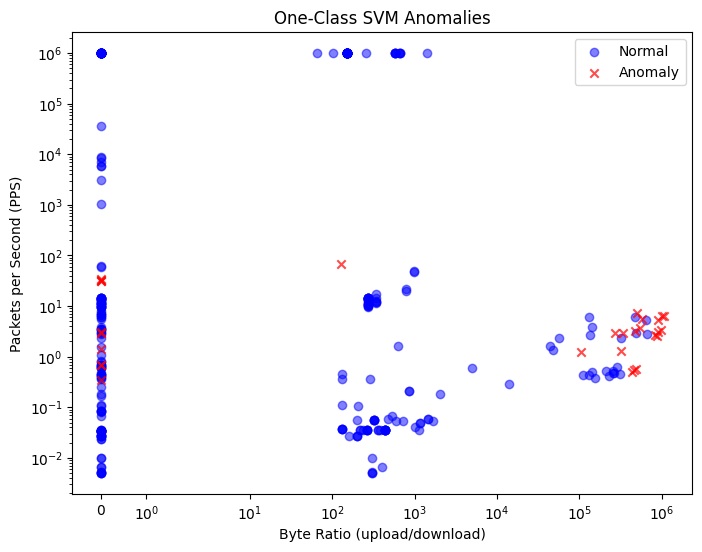

In [29]:
import matplotlib.pyplot as plt

# ----------------------------
# Scatterplot function
# ----------------------------
def plot_anomalies(x, y, labels, title):
    plt.figure(figsize=(8,6))
    plt.scatter(x[labels==1], y[labels==1], c="blue", label="Normal", alpha=0.5)
    plt.scatter(x[labels==-1], y[labels==-1], c="red", label="Anomaly", alpha=0.7, marker="x")
    plt.xscale("symlog")  # handle 0 and very large ratios
    plt.yscale("log")
    plt.xlabel("Byte Ratio (upload/download)")
    plt.ylabel("Packets per Second (PPS)")
    plt.title(title)
    plt.legend()
    plt.show()

# ----------------------------
# Plot for Isolation Forest
# ----------------------------
plot_anomalies(df["byte_ratio"].values,
               df["pps"].values,
               df["isf_pred"].values,
               "Isolation Forest Anomalies")

# ----------------------------
# Plot for One-Class SVM
# ----------------------------
plot_anomalies(df["byte_ratio"].values,
               df["pps"].values,
               df["ocsvm_pred"].values,
               "One-Class SVM Anomalies")


Both algorithms should paint Cluster 2 (upload-heavy, far right) red (flagged).

Isolation Forest may scatter a few red X’s in handshake flows (bottom left).

One-Class SVM will likely paint more red in the interactive cluster (middle-top).